Here we'll show the DGP for regression, using small to medium data sets.

In [62]:
import sys
sys.path.append('../src')
sys.path.append('../../DNSGP/GPflow')

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline 

from GPflow.likelihoods import Gaussian
from GPflow.kernels import RBF, White, Linear, Matern32, Matern52
from GPflow.mean_functions import Constant
from GPflow.sgpr import SGPR
from GPflow.gpr import GPR

from scipy.cluster.vq import kmeans2

from get_data import get_regression_data
from dgp import DGP

Let's start with the energy data set. 

In [63]:
X, Y, Xs, Ys = get_regression_data('energy', 0)
Y_mean, Y_std = np.average(Y), np.std(Y)
D = X.shape[1]
print 'N: {}, D: {}, Ns: {}'.format(X.shape[0], D, Xs.shape[0])

N: 690, D: 8, Ns: 77


This is quite a small dataset, so we can train a full GP for a benchmark. We'll use the RBF kernel and set the initial hyperparameters sensibly. We use a constant mean function as we haven't centered the outputs. 

Sine we've already whitened the inputs we can use the default lengthscale of 1. A better choice might be to set to the median of the squared distances, but we won't do that here. 

In [72]:
# kernel = White(D, variance=1e-5) + Linear(D)
# kernel = RBF(D, variance=Y_std**2) + White(D, variance=1e-5) + Linear(D)
kernel = RBF(D, variance = Y_std**2) + White(D)

m_gp = GPR(X, Y, kernel, 
           mean_function=Constant(Y_mean))
# m_gp.mean_function.fixed = True
m_gp.likelihood.variance = 0.1 * Y_std

We can optimize this model with LBFGS and find the log likelihood on the test data

In [73]:
m_gp.optimize()
l_gp = np.average(m_gp.predict_density(Xs, Ys))
print 'full GP test log likelihood {:.4f}'.format(np.average(l_gp))
print m_gp

full GP test log likelihood -0.4996
name.kern.rbf.lengthscales transform:+ve prior:None
[ 18.05939605]
name.kern.rbf.variance transform:+ve prior:None
[  1.18154036e+08]
name.kern.white.variance transform:+ve prior:None
[  1.00000000e-06]
name.likelihood.variance transform:+ve prior:None
[ 0.16478242]
name.mean_function.c transform:(none) prior:None
[-3182.96989063]


Now we'll train a sparse GP with 100 inducing points

In [37]:
M = 100
Z = kmeans2(X, M, minit='points')[0] 

m_sgp = SGPR(X, Y, RBF(D, variance=Y_std**2) + White(D, variance=1e-5),
             Z.copy(),
             mean_function=Constant(Y_mean))
m_sgp.mean_function.fixed = True
m_sgp.likelihood.variance = 0.1 * Y_std


In [38]:
m_sgp.optimize()
l_sgp = np.average(m_sgp.predict_density(Xs, Ys))
print 'sparse GP test log likelihood {:.4f}'.format(np.average(l_sgp))
print m_sgp.kern
print m_sgp.likelihood

sparse GP test log likelihood -1.5538
kern.rbf.variance transform:+ve prior:None
[ 109.39381]
kern.rbf.lengthscales transform:+ve prior:None
[ 2.18075006]
kern.white.variance transform:+ve prior:None
[  8.00483533e-06]
likelihood.variance transform:+ve prior:None
[ 1.47848175]


We'll now construct DGPs of 1, 2 and 3 layers. We'll use the RBF kernel for each layer, with a small noise between each layer 

In [74]:
def make_dgp(L):
    kernels = []
    for l in range(L):
        kernels.append(RBF(D, lengthscales=1., variance=1.))
    model = DGP(X, Y, X.copy(), kernels, Gaussian(), num_samples=1)

    model.layers[-1].kern.variance = Y_std**2
    model.likelihood.variance = Y_std*0.1 
    model.layers[-1].mean_function = Constant(Y_mean)
    model.layers[-1].mean_function.fixed = True
    
    # start the inner layers deterministically 
    for layer in model.layers[:-1]:
        layer.q_sqrt = layer.q_sqrt.value * 1e-5
    
    for layer in model.layers:
        layer.Z.fixed = True
    return model
m_dgp1 = make_dgp(1)
m_dgp2 = make_dgp(2)
# m_dgp3 = make_dgp(3)

We'll train all three models using the Adam optimizer. Note that the 1 layer model is equivalent to m_sgp above


When stochastically optimizing it's useful to have a callback to see what's going on

In [75]:
class CB(object):
    def __init__(self, model, record_every=10):
        self.model = model
        self.i = 0
        self.res = []
        self.record_every = record_every
    def cb(self, x):
        self.i += 1
        if self. i % self.record_every == 0:
            self.model.set_state(x)
            self.res.append(self.model.compute_log_likelihood())

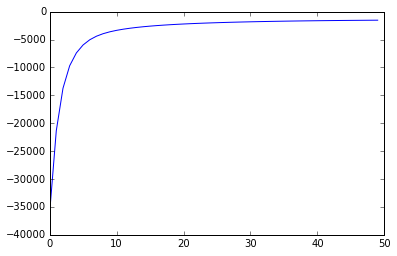

Caught KeyboardInterrupt, setting model                  with most recent state.


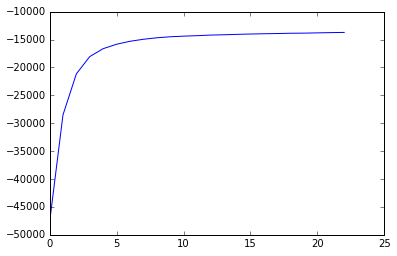

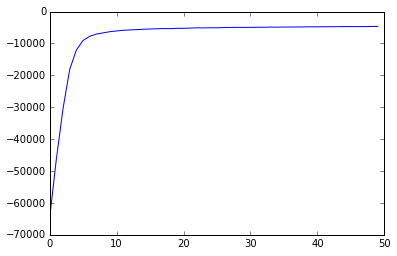

In [76]:
for m in [m_dgp1, m_dgp2, m_dgp3]:
    cb = CB(m)
    m.optimize(tf.train.AdamOptimizer(0.01), 
               maxiter=500, 
               callback=cb.cb)
    plt.plot(cb.res)
    plt.show()    

In these models we have to predict stochastically, using a Gaussian mixture. The DGP class has a built-in method to do this

In [77]:
s = 'DGP with {} layers, {} samples, test loglikelihood {:.4f}'
for m in [m_dgp1, m_dgp2, m_dgp3]:
    for S in [1, 10, 100]:
        for _ in range(3):
            l = m.predict_density(Xs, Ys, S)
            print s.format(len(m.layers), S, np.average(l))

DGP with 1 layers, 1 samples, test loglikelihood -1.6605
DGP with 1 layers, 1 samples, test loglikelihood -1.6605
DGP with 1 layers, 1 samples, test loglikelihood -1.6605
DGP with 1 layers, 10 samples, test loglikelihood -1.6605
DGP with 1 layers, 10 samples, test loglikelihood -1.6605
DGP with 1 layers, 10 samples, test loglikelihood -1.6605
DGP with 1 layers, 100 samples, test loglikelihood -1.6605
DGP with 1 layers, 100 samples, test loglikelihood -1.6605
DGP with 1 layers, 100 samples, test loglikelihood -1.6605
DGP with 2 layers, 1 samples, test loglikelihood -1.4844
DGP with 2 layers, 1 samples, test loglikelihood -1.4946
DGP with 2 layers, 1 samples, test loglikelihood -1.4134
DGP with 2 layers, 10 samples, test loglikelihood -1.4416
DGP with 2 layers, 10 samples, test loglikelihood -1.4493
DGP with 2 layers, 10 samples, test loglikelihood -1.4414
DGP with 2 layers, 100 samples, test loglikelihood -1.4479
DGP with 2 layers, 100 samples, test loglikelihood -1.4428
DGP with 2 laye

In [ ]:











    


# for L in [1, 2, 3]:
#     model = make_dgp(L)
#     cb = CB(model, 100)
#     if L == 1:
#         model.optimize(maxiter=2000, callback=cb.cb)
#     else:    
#         model.optimize(tf.train.AdamOptimizer(0.01), maxiter=2000, callback=cb.cb)
    
#     S = 100
#     for _ in range(2):
#         m, v = model.predict_y(Xs, S)
#         Ys_ = Ys[None, :, :] * np.ones((S, 1, 1))
#         logliks = norm.logpdf(Ys_, loc=m, scale=v**0.5)
#         a = logsumexp(logliks, axis=0, b=1/float(S))
#         #print np.average(a)
#         print np.average(logliks)
    
#     for _ in range(2):
#         ll = model.predict_density(Xs, Ys, S)
#         print np.average(ll)
    
#     plt.plot(cb.res)
#     plt.show()
#
#for n in [1, 10, 100]:
#    print n
#    for _ in range(3):
#        test_log_likelihood = model.predict_density(Xs, Ys, n)
#        a = logsumexp(test_log_likelihood, axis=0, b=1/float(test_log_likelihood.shape[0]))
#        print np.average(a)
##        m, v = m_dgp
#
#
#






